In [1]:
import numpy as np

from utils import read_and_standardize, extract_features

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Get features

In [2]:
k = 5
adj_matrices = read_and_standardize('data/SysFlows.pkl')

X = np.concatenate([
    extract_features(adj_mat, k)
    for adj_mat in adj_matrices
])

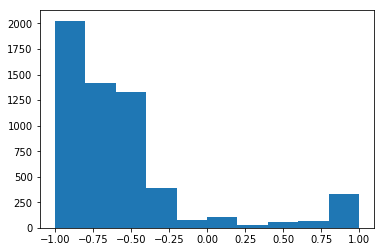

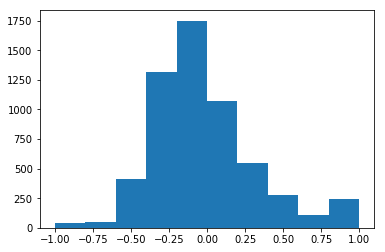

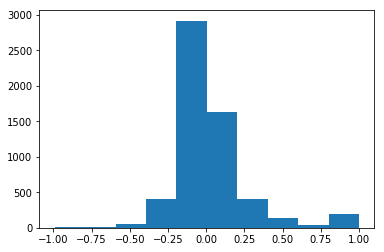

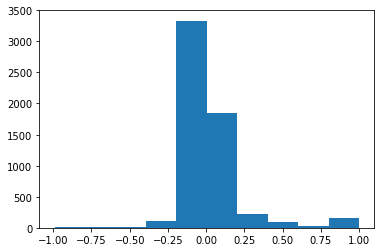

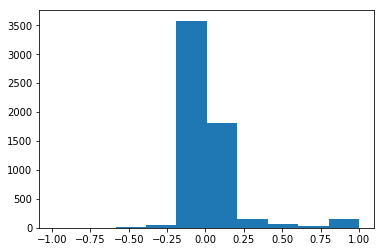

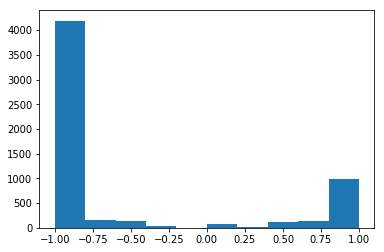

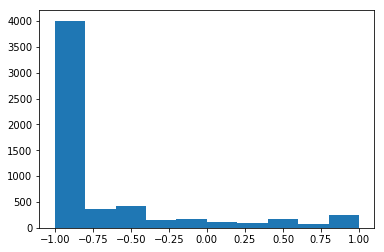

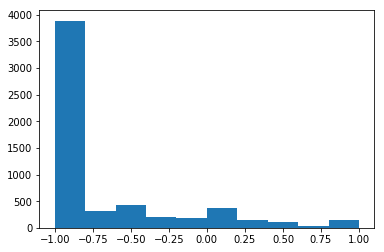

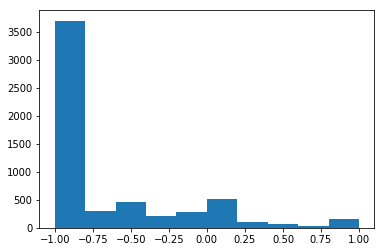

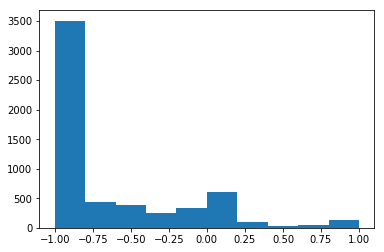

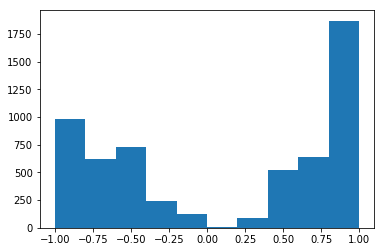

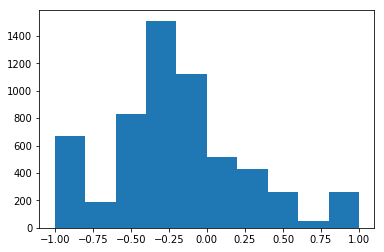

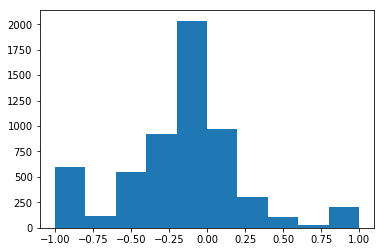

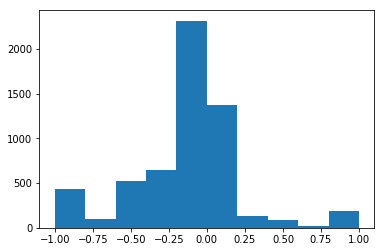

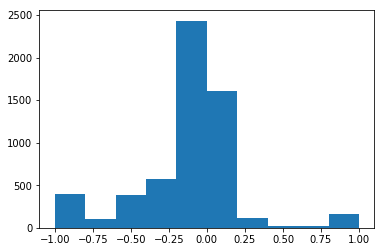

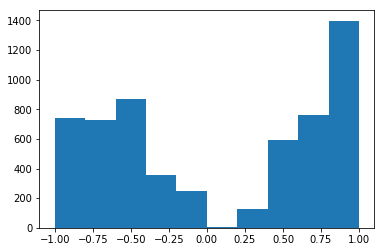

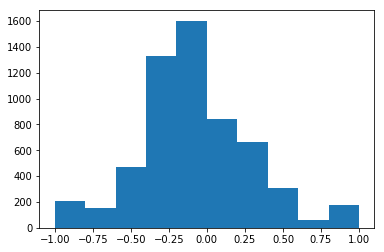

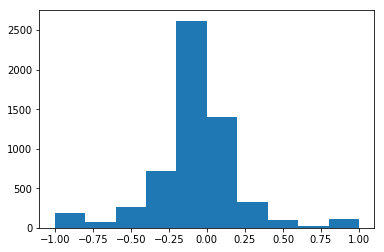

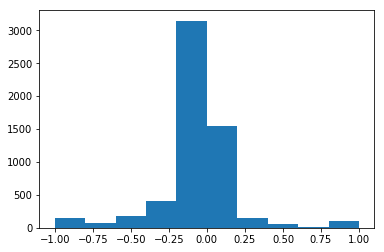

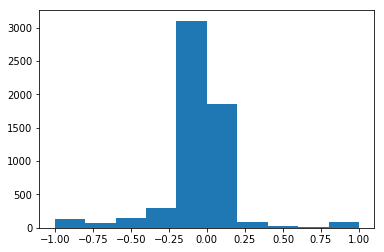

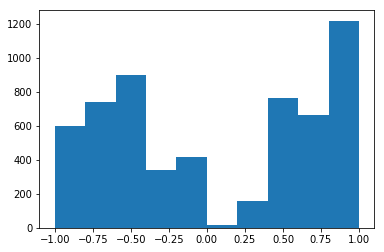

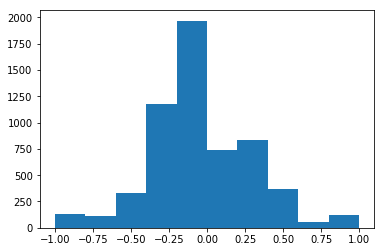

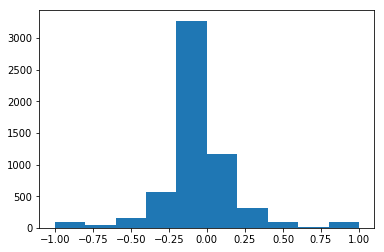

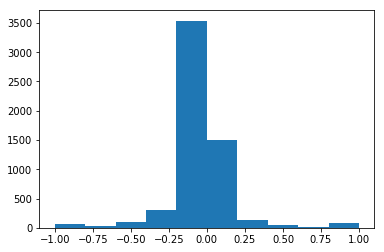

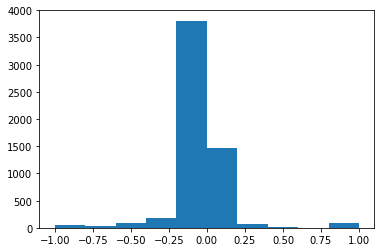

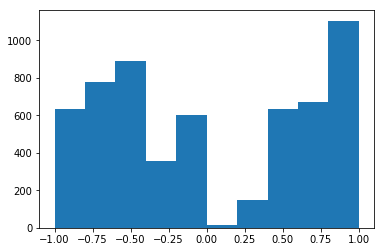

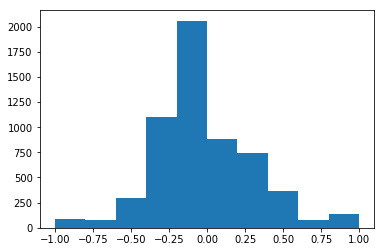

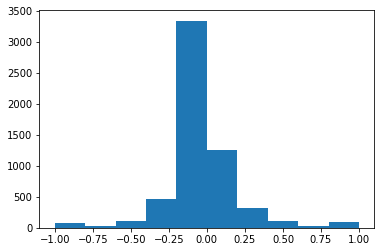

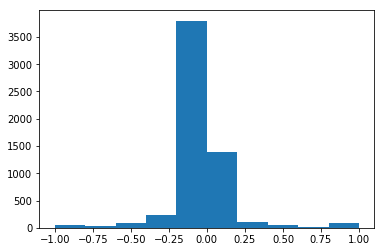

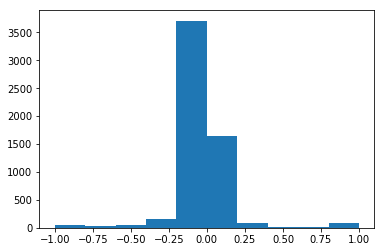

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


for col_i in range(X.shape[1]):
    plt.hist(X[:, col_i])
    plt.show()

## Define the Denoising AutoEncoder (DAE)

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2


embedd_dim = 2

n_rows, n_feats = X.shape
dense_kwargs = {
    'units': n_feats,
    'activation': 'relu',
    'kernel_regularizer': l2(1e-4),
}


inp = Input(shape=(n_feats, ))

encoder1 = Dense(**dense_kwargs)(inp)
encoder2 = Dense(**dense_kwargs)(encoder1)

bottleneck = Dense(embedd_dim, activation='tanh')(encoder2)

decoder1 = Dense(**dense_kwargs)(bottleneck)
decoder2 = Dense(**dense_kwargs)(decoder1)

out = Dense(n_feats, activation='linear')(decoder2)


dae = Model(inputs=inp, outputs=out)

dae.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# And now, fit the DAE

In [5]:
BATCH_SIZE = 128
STEPS_PER_EPOCH = X.shape[0] // BATCH_SIZE
EPOCHS = 1000

In [6]:
from dae import SwapNoiseGenerator


PROB_SWAP = 0.05


swap_noise_generator = SwapNoiseGenerator(PROB_SWAP)
batch_generator = swap_noise_generator.batch_generator(X, BATCH_SIZE)

In [7]:
%%time
history = dae.fit_generator(
    generator=batch_generator, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=False,
)

CPU times: user 2min 5s, sys: 9.42 s, total: 2min 15s
Wall time: 1min 11s


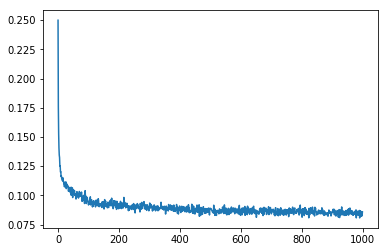

In [8]:
plt.plot(history.history['loss']);

In [9]:
X_pred = dae.predict(X)

In [10]:
diffs = (X - X_pred).flatten()
diffs.mean(), diffs.std()

(0.003930111348023286, 0.2740723549043081)

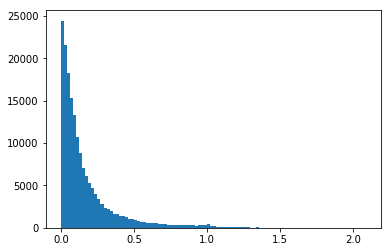

In [11]:
plt.hist(np.abs(diffs), bins=100);

In [12]:
embedd = Model(inputs=inp, outputs=bottleneck)

X_embedded = embedd.predict(X)

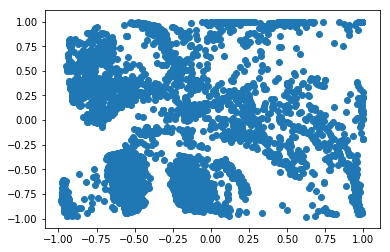

In [13]:
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1]);

In [14]:
graph_slices = []

tmp_idx = 0
for adj_mat in adj_matrices:
    graph_size = len(adj_mat)
    graph_slices.append(slice(tmp_idx, tmp_idx+graph_size))
    tmp_idx += graph_size

## Let's see where on this plot can we find detrita

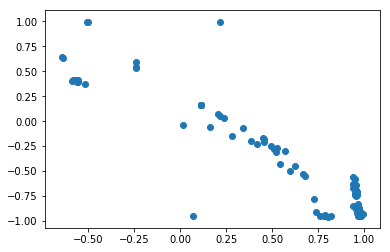

In [15]:
X_dent = np.r_[[
    X_embedded[slc][-1, :]
    for slc in graph_slices
]]
plt.scatter(x=X_dent[:,0], y=X_dent[:,1]);

## Let's see two graphs on one plot

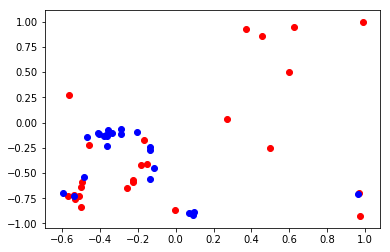

In [16]:
graph1 = 0
graph2 = 1

slc1 = graph_slices[graph1]
slc2 = graph_slices[graph2]

X1 = X_embedded[slc1, :]
X2 = X_embedded[slc2, :]

plt.scatter(x=X1[:,0], y=X1[:,1], c='r')
plt.scatter(x=X2[:,0], y=X2[:,1], c='b')
plt.show();

In [17]:
from sklearn.metrics.pairwise import rbf_kernel


dist = rbf_kernel(X1, X2)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [18]:
def graph_similarity(graph1, graph2, graph_slices, X_embedded):
    slc1 = graph_slices[graph1]
    slc2 = graph_slices[graph2]

    X1 = X_embedded[slc1, :]
    X2 = X_embedded[slc2, :]
    
    return rbf_kernel(X1, X2).mean()

In [19]:
%%time
graph_sim_mat = np.array([
    [
        graph_similarity(i, j, graph_slices, X_embedded)
        for j in range(len(graph_slices))
    ]
    for i in range(len(graph_slices))
])




CPU times: user 8.22 s, sys: 4.62 s, total: 12.8 s
Wall time: 6.31 s


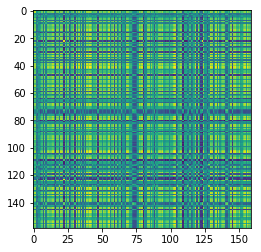

In [20]:
plt.imshow(graph_sim_mat);

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


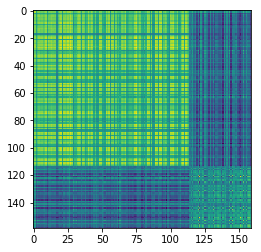

In [21]:
from sklearn.cluster import SpectralClustering


num_clusters = 2

spec_clust = SpectralClustering(n_clusters=num_clusters, affinity='precomputed')

spec_clust.fit(graph_sim_mat)

idxes = sum([
    list(np.where(spec_clust.labels_.astype(np.int)==clust_i)[0])
    for clust_i in range(num_clusters)
], [])

plt.imshow(graph_sim_mat[idxes, :][:, idxes]);